## Overview

This notebook explores death by time of year using the 2014 CDC mortality dataset found on [Kaggle](https://www.kaggle.com/cdc/mortality).

In [1]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla

In [3]:
# Connect to SQLite database found in data/database.sqlite

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///data/database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)

SELECT "DeathRecords"."MonthOfDeath", count("DeathRecords"."MonthOfDeath") AS "Number of Deaths" 
FROM "DeathRecords" GROUP BY "DeathRecords"."MonthOfDeath"


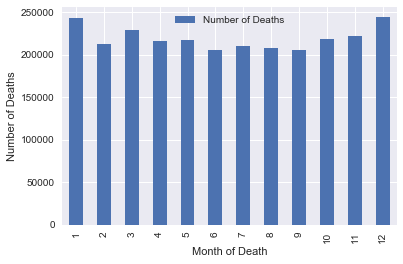

In [16]:
%matplotlib inline

# Connect to engine

conn = engine.connect()

# Generate statement
stmt = sqla.select([tables["DeathRecords"].columns.MonthOfDeath, 
                    sqla.func.count(tables["DeathRecords"].columns.MonthOfDeath).label('Number of Deaths')])

stmt = stmt.group_by(tables["DeathRecords"].columns.MonthOfDeath)

print(stmt)

count = pd.read_sql_query(stmt, conn)

count.plot(x = 'MonthOfDeath', y = 'Number of Deaths', kind = 'bar')
plt.xlabel("Month of Death")
plt.ylabel("Number of Deaths")